In [1]:
import os
os.chdir('/mnt/ialabnas/homes/fidelrio/systematic-text-representations/')

from collections import defaultdict
import json
from pathlib import Path
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import torch

from config import load_config
from data import build_datasets, build_loader, build_detailed_test_dataloaders
from data import CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator
from data import ALL_POSSIBLE_COLORS
from model import MultimodalModel, MultimodalPretrainingModel
from utils import load_checkpoint
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.nn.functional import softmax

import numpy as np
from sklearn.decomposition import PCA

pp = pprint.PrettyPrinter(indent=2)

2024-09-26 09:41:59.991876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64/
2024-09-26 09:41:59.991906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

In [3]:
device = torch.device('cuda')

n_colors = 8
epoch = None
exp_name = f'mmlm--n_colors={n_colors}c--mlm_probability=0.15'

checkpoint = load_checkpoint(exp_name, epoch=epoch)
print('Epoch:', checkpoint['epoch'])

Epoch: 999


In [4]:
!ls outputs/$exp_name

'epoch=149-step=22050.ckpt'  'epoch=649-step=95550.ckpt'
'epoch=199-step=29400.ckpt'  'epoch=699-step=102900.ckpt'
'epoch=19-step=2940.ckpt'    'epoch=69-step=10290.ckpt'
'epoch=249-step=36750.ckpt'  'epoch=749-step=110250.ckpt'
'epoch=299-step=44100.ckpt'  'epoch=799-step=117600.ckpt'
'epoch=29-step=4410.ckpt'    'epoch=79-step=11760.ckpt'
'epoch=349-step=51450.ckpt'  'epoch=849-step=124950.ckpt'
'epoch=399-step=58800.ckpt'  'epoch=899-step=132300.ckpt'
'epoch=39-step=5880.ckpt'    'epoch=89-step=13230.ckpt'
'epoch=449-step=66150.ckpt'  'epoch=949-step=139650.ckpt'
'epoch=499-step=73500.ckpt'  'epoch=999-step=147000.ckpt'
'epoch=49-step=7350.ckpt'    'epoch=99-step=14700.ckpt'
'epoch=549-step=80850.ckpt'  'epoch=9-step=1470.ckpt'
'epoch=599-step=88200.ckpt'   last.ckpt
'epoch=59-step=8820.ckpt'


In [5]:
config = load_config(exp_name)

config.vocabulary_path = config.vocabulary_path.replace('/workspace/' ,'/workspace1/')
config.base_path = config.base_path.replace('/workspace/' ,'/workspace1/')

# pp.pprint(vars(config))

train_dataset, test_dataset, systematic_dataset, common_systematic_dataset = build_datasets(config)
config.pad_idx = train_dataset.pad_idx
config.n_tokens = train_dataset.n_tokens

complete_dataset = ConcatDataset((test_dataset, systematic_dataset))

processor = test_dataset.processor
mask_token_idx = processor.vocabulary['[MASK]']
pad_token_idx = processor.vocabulary['[PAD]']

# test_loaders = build_detailed_test_dataloaders(test_dataset, config) # type_of_tokens_to_test
# systematic_loaders = build_detailed_test_dataloaders(systematic_dataset, config) # type_of_tokens_to_test

model = MultimodalModel(config).to(device)
training_model = MultimodalPretrainingModel(model, config).to(device)
training_model.load_state_dict(checkpoint['state_dict'])

Loading mmlm--n_colors=8c--mlm_probability=0.15 last checkpoint config from outputs/mmlm--n_colors=8c--mlm_probability=0.15/last.ckpt
Add new arg: permute_pixels = False
Add new arg: aug_zero_color = False


/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


<All keys matched successfully>

In [6]:
vocab = processor.vocabulary

relation_tokens = sorted(
    [vocab[w] for w in ['left', 'right', 'behind', 'front'] if w in vocab])
colors_tokens = sorted(
    [vocab[w] for w in ALL_POSSIBLE_COLORS if w in vocab])
#     [vocab[w] for w in ['blue', 'brown', 'cyan', 'green', 'red', 'purple', 'yellow', 'gray']])
shapes_tokens = sorted(
    [vocab[w] for w in ['cylinder', 'sphere', 'cube'] if w in vocab])
materials_tokens = sorted(
    [vocab[w] for w in ['metal', 'rubber'] if w in vocab])
sizes_tokens = sorted(
    [vocab[w] for w in ['small', 'large'] if w in vocab])

random_baseline = {
    'relation':  1 / len(relation_tokens),
    'color':  1 / len(colors_tokens),
    'shapes':  1 / len(shapes_tokens),
    'materials':  1 / len(materials_tokens),
    'size':  1 / len(sizes_tokens),
    'identity':  1 / len(processor.vocabulary),
}

In [7]:
batch_size = 1024
test_indices = random.sample(range(len(test_dataset)), k=batch_size)
pc_subset_test = Subset(test_dataset, test_indices)
pc_subset_systematic = Subset(systematic_dataset, test_indices)
pc_subset_complete = Subset(complete_dataset, test_indices)

colors_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=colors_tokens)
shapes_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=shapes_tokens)
materials_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=materials_tokens)
sizes_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=sizes_tokens)
dlkwargs = {
    'batch_size': batch_size,
    'num_workers': int(os.environ.get("SLURM_CPUS_PER_TASK", 4)),
    'pin_memory': torch.cuda.is_available(),
}

test_loaders = {}
systematic_loaders = {}
complete_loaders = {}
for task, collator in [('colors', colors_collator),
                       ('shapes', shapes_collator),
                       ('materials', materials_collator),
                       ('sizes', sizes_collator)]:
    
    test_loaders[task] = DataLoader(
        pc_subset_test, shuffle=True, collate_fn=collator, **dlkwargs)
    systematic_loaders[task] = DataLoader(
        pc_subset_systematic, shuffle=True, collate_fn=collator, **dlkwargs)
    complete_loaders[task] = DataLoader(
        pc_subset_complete, shuffle=True, collate_fn=collator, **dlkwargs)

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map

def hook_feat_map(mod, inp, out):
    feature_maps.clear()
    feature_maps.append(out)

model.transformer.register_forward_hook(hook_feat_map)

In [9]:
def get_props(scenes):
    sizes = scenes[:,1:][:,0::5]
    colors = scenes[:,1:][:,1::5]
    materials = scenes[:,1:][:,2::5]
    shapes = scenes[:,1:][:,3::5]

    sizes = sizes[sizes != pad_token_idx].cpu()
    colors = colors[colors != pad_token_idx].cpu()
    materials = materials[materials != pad_token_idx].cpu()
    shapes = shapes[shapes != pad_token_idx].cpu()
    return sizes, colors, materials, shapes

In [10]:
# tasks = ['colors', 'shapes', 'materials', 'sizes']

# feats_by_set = {}
# gt_by_set = {}
# props_by_set = {}
# for test_name, loader in [('test', test_loaders), ('systematic', systematic_loaders)]:
#     feats_by_task = {}
#     gt_by_task = {}
#     props_by_task = {}
#     for task in tasks:
#         images, scenes, labels = next(iter(loader[task]))
#         images, scenes, labels = images.to(device), scenes.to(device), labels.to(device)
#         cimages, cscenes, clabels = images, scenes, labels
#         with torch.no_grad():
#             output_logits = model(images, scenes)

#             features = feature_maps[0]
#             confidences = softmax(output_logits, dim=-1).max(dim=-1).values
#             predictions = output_logits.argmax(dim=-1)

#             scene_features = features.transpose(1,0)[:,-config.max_scene_size:]
#             mask_idxs = (scenes == mask_token_idx)
#             gt_by_task[task] = labels[:,-config.max_scene_size:][mask_idxs].cpu()
#             feats_by_task[task] = scene_features[mask_idxs].cpu()
#             props_by_task[task] = get_props(scenes)
#             sizes, colors, materials, shapes = props_by_task[task]
   
#     feats_by_set[test_name] = feats_by_task
#     gt_by_set[test_name] = gt_by_task
#     props_by_set[test_name] = props_by_task

In [11]:
# clf_idxs = torch.unique(torch.cat([gt_by_set['test'][t] for t in tasks]))
# clf_idxs_by_task = {t: torch.unique(gt_by_set['test'][t]) for t in tasks}
# all_clf_vectors = model.classifier.weight.data.cpu()
# clf_vectors = model.classifier.weight.data.cpu()[clf_idxs]
# clf_vectors_by_task = {t: all_clf_vectors[tidxs] for t, tidxs in clf_idxs_by_task.items()}
# all_word_vectors = model.word_embedding.weight.data.cpu()
# word_vectors = model.word_embedding.weight.data.cpu()[clf_idxs]
# word_vectors_by_task = {t: all_clf_vectors[tidxs] for t, tidxs in clf_idxs_by_task.items()}

In [12]:
# for test_name, loader in [
#         ('test', test_loaders), ('systematic', systematic_loaders), ('complete', complete_loaders)]:
#     for task in tasks:

In [13]:
task = 'shapes'
loader = complete_loaders

task_idx = ['sizes', 'colors', 'materials', 'shapes'].index(task)

images, scenes, labels = next(iter(loader[task]))
images, scenes, labels = images.to(device), scenes.to(device), labels.to(device)
with torch.no_grad():
    output_logits = model(images, scenes)

    features = feature_maps[0]
    confidences = softmax(output_logits, dim=-1).max(dim=-1).values
    predictions = output_logits.argmax(dim=-1)

    scene_features = features.transpose(1,0)[:,-config.max_scene_size:]
    mask_idxs = (scenes == mask_token_idx)
    gt = labels[:,-config.max_scene_size:][mask_idxs].cpu()
    feats = scene_features[mask_idxs].cpu()
    props = get_props(scenes)
    sizes, colors, materials, shapes = props



prop_stack = [sizes, colors, materials, shapes]
prop_stack[task_idx] = gt
prop_stack = torch.stack(prop_stack, dim=-1).tolist()
prop_index = defaultdict(list)
for idx, props in enumerate(prop_stack):
    props = tuple(props)
    prop_index[props].append(idx)

    
unique_sizes = sizes.unique().tolist()
unique_colors = colors.unique().tolist()
unique_materials = materials.unique().tolist()
unique_shapes = shapes.unique().tolist()
unique_tokens = [
    unique_sizes,
    unique_colors,
    unique_materials,
    unique_shapes,
]

unique_gts = gt.unique().tolist()
unique_tokens[task_idx] = unique_gts

In [42]:
from itertools import product, combinations

def all_possible_dichotomies(unique_tokens, dichotomy_within_task_idx=None):
    dichotomies = set()
    for dichotomic_tokens_idx in range(len(unique_tokens)):
        if dichotomy_within_task_idx is not None:
            if dichotomic_tokens_idx != dichotomy_within_task_idx:
                continue

        context_tokens = unique_tokens[:dichotomic_tokens_idx] + unique_tokens[dichotomic_tokens_idx+1:]
        dichotomic_tokens = unique_tokens[dichotomic_tokens_idx]
        for dichotomic_pair in combinations(dichotomic_tokens, r=2):
            for pair in [dichotomic_pair, tuple(reversed(dichotomic_pair))]:
                for context0 in product(*context_tokens):
                    for context1 in product(*context_tokens):
                        if context0 == context1:
                            continue

                        a, b = pair
                        if a == b:
                            continue
                        from_v0 = list(context0).copy()
                        from_v0.insert(dichotomic_tokens_idx, a)
                        from_v1 = list(context1).copy()
                        from_v1.insert(dichotomic_tokens_idx, a)
                        to_v0 = list(context0).copy()
                        to_v0.insert(dichotomic_tokens_idx, b)
                        to_v1 = list(context1).copy()
                        to_v1.insert(dichotomic_tokens_idx, b)

                        dichotomies.add((tuple(from_v0),
                                            tuple(from_v1),
                                            tuple(to_v0),
                                            tuple(to_v1)))

    return list(dichotomies)


def is_possible(from_v0, from_v1, to_v0, to_v1, prop_index):
    if not prop_index[from_v0]:
        return False
    if not prop_index[from_v1]:
        return False
    if not prop_index[to_v0]:
        return False
    if not prop_index[to_v1]:
        return False
    return True


def all_possible_triplets(unique_tokens, only_task_mod_ids=None):
    only_task_mod_idx1 = only_task_mod_idx2 = None
    if only_task_mod_ids is not None:
        only_task_mod_idx1, only_task_mod_idx2 = only_task_mod_ids
        
    task_ids = list(range(len(unique_tokens)))
    
    triplets = set()
    context_tokens = unique_tokens.copy()
    for context in product(*context_tokens):
        for task_mod_idx1, task_mod_idx2 in combinations(task_ids, r=2):
            if task_mod_idx1 == task_mod_idx2:
                    continue

            if only_task_mod_ids is not None:
                if only_task_mod_idx1 is not None and task_mod_idx1 != only_task_mod_idx1: 
                    continue
                if only_task_mod_idx2 is not None and task_mod_idx2 != only_task_mod_idx2:
                    continue
                    
            tokens_mod1 = unique_tokens[task_mod_idx1]
            tokens_mod2 = unique_tokens[task_mod_idx2]
            for token_mod_idx1, token_mod_idx2 in product(tokens_mod1, tokens_mod2):
                if context[task_mod_idx1] == token_mod_idx1:
                    continue
                if context[task_mod_idx2] == token_mod_idx2:
                    continue
                
                pivot = list(context).copy()
                v1 = list(context).copy()
                v1[task_mod_idx1] = token_mod_idx1
                v2 = list(context).copy()
                v2[task_mod_idx2] = token_mod_idx2
                triplets.add((tuple(pivot),
                              tuple(v1),
                              tuple(v2)))
    return list(triplets)

In [49]:
triplets = all_possible_triplets(unique_tokens, only_task_mod_ids=(1,3))

In [50]:
len(triplets)

1344

In [45]:
random.choice(triplets)

((83, 20, 66, 84), (83, 21, 66, 84), (83, 20, 66, 42))

In [46]:
random.choice(triplets)

((59, 17, 77, 42), (59, 19, 77, 42), (59, 17, 77, 40))

In [47]:
random.choice(triplets)

((83, 18, 77, 42), (83, 21, 77, 42), (83, 18, 77, 84))

In [48]:
random.choice(triplets)

((59, 19, 77, 42), (59, 18, 77, 42), (59, 19, 66, 42))

In [48]:
dichotomies = all_possible_dichotomies(unique_tokens, only_task_idx=0)
possible_dichotomies = [p for p in dichotomies if is_possible(*p, prop_index=prop_index)]

(267, 291)
(291, 267)


In [49]:
len(dichotomies)

3356640

In [61]:
import random

def print_dichotomy(dichotomy):
    from_v0, from_v1, to_v0, to_v1 = dichotomy
    print(from_v0, '->', to_v0)
    print(from_v1, '->', to_v1)

print_dichotomy(random.choice(dichotomies))

(291, 164, 274, 292) -> (267, 164, 274, 292)
(291, 67, 285, 292) -> (267, 67, 285, 292)


In [23]:
from tqdm.auto import tqdm

n_samples = 20
n_sampled_dichotomies = 3500

if n_sampled_dichotomies < len(possible_dichotomies):
    sampled_dichotomies = random.sample(possible_dichotomies, k=n_sampled_dichotomies)
else:
    sampled_dichotomies = possible_dichotomies

p_scores = []
for from_v0, from_v1, to_v0, to_v1 in tqdm(sampled_dichotomies):
    for _ in range(n_samples):
        from_v0_idx = random.choice(prop_index[from_v0])
        from_v1_idx = random.choice(prop_index[from_v1])
        to_v0_idx = random.choice(prop_index[to_v0])
        to_v1_idx = random.choice(prop_index[to_v1])

        vec0 = feats[to_v0_idx] - feats[from_v0_idx]
        vec1 = feats[to_v1_idx] - feats[from_v1_idx]

        p_score = vec0 @ vec1 / (vec0.norm() * vec1.norm())
        p_scores.append(float(p_score))

  0%|          | 0/3500 [00:00<?, ?it/s]

In [24]:
print(f'{len(p_scores)} scores computed')
print(f'{len(prop_index)} property combinations')
print(f'{len(dichotomies)} parallelograms')
print()
print(f'Mean Parallelism Score: {float(torch.tensor(p_scores).mean()):.4f}')

70000 scores computed
2592 property combinations
8658576 parallelograms

Mean Parallelism Score: 0.2756


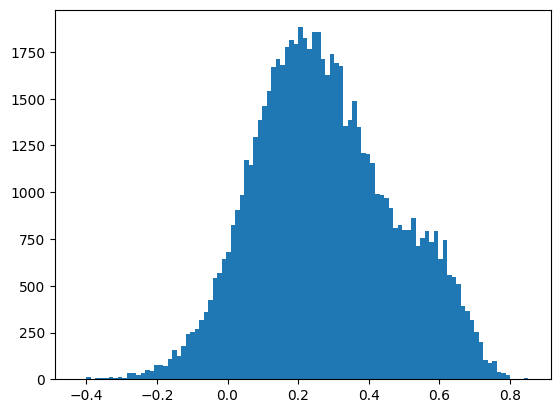

In [25]:
plt.hist(p_scores, bins=100)
plt.show()

In [26]:
# def is_parallelogram(p1, p2, p3, p4):
#     # Function to calculate vector between two points
#     def vector(a, b):
#         return (b[0] - a[0], b[1] - a[1])

#     # Function to check if two vectors are equal
#     def are_vectors_equal(v1, v2):
#         return v1 == v2

#     # Get the vectors for opposite sides
#     v1 = vector(p1, p2)  # Vector from p1 to p2
#     v2 = vector(p3, p4)  # Vector from p3 to p4
#     v3 = vector(p1, p4)  # Vector from p1 to p4
#     v4 = vector(p2, p3)  # Vector from p2 to p3

#     # Opposite sides should have equal vectors for it to be a parallelogram
#     return are_vectors_equal(v1, v2) and are_vectors_equal(v3, v4)

# all(is_parallelogram(*p) for p in parallelograms)

In [27]:
assert False

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 assert False                                                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

In [ ]:
def scatter_pca(X,
                y, 
                title='', 
                special_X=None, 
                special_y=None, 
                don_t_label_these=[], 
                labels_to_use=[], 
                special_labels_to_use=[], 
                ax=None):
    
    is_3d = X.shape[-1] == 3
    
    if ax is None:
        fig = plt.figure(figsize=(9*1.75,5*1.75))
        if is_3d:
            ax = fig.add_subplot(projection='3d')
        else:
            ax = fig.add_subplot()

    label_namer = processor.inv_vocabulary
    if labels_to_use:
        label_namer = labels_to_use
    for label_idx in sorted(set(y)):
        idxs = y == label_idx 
        label = label_namer[label_idx]

        plot_args = [X[:,0][idxs], X[:,1][idxs]]
        if is_3d:
            plot_args = plot_args + [X[:,2][idxs]]

        plot_kwargs = {}
        if not don_t_label_these or label not in don_t_label_these:
            plot_kwargs['label'] = label

        scatter_shapes = ax.scatter(*plot_args, **plot_kwargs)
  
    special_label_namer = processor.inv_vocabulary
    if labels_to_use:
        special_label_namer = labels_to_use
    if special_labels_to_use:
        special_label_namer = special_labels_to_use
    if special_X is not None:
        for label_idx in sorted(set(special_y)): 
            label = special_label_namer[label_idx]

            plot_kwargs = {}
            if not don_t_label_these or label not in don_t_label_these:
                plot_kwargs['label'] = label

            special_idxs = special_y == label_idx 
            special_plot_args = [special_X[:,0][special_idxs], special_X[:,1][special_idxs]]
            if is_3d:
                special_plot_args = special_plot_args + [special_X[:,2][special_idxs]]

#             color = scatter_shapes.get_facecolors()[0]
#             plot_kwargs['color'] = color
            plot_kwargs['marker'] = '*'
            if not is_3d:
                plot_kwargs['s'] = 200
        
            ax.scatter(*special_plot_args, **plot_kwargs)


    if title:
        ax.set_title(title)
    ax.legend(framealpha=1, loc='upper left')

    # Show plot
    # plt.savefig('exports/base-attributes.pdf', format='pdf', dpi=300, bbox_inches='tight')
    if not ax:
        plt.show()

In [ ]:
don_t_label_these = [] if n_colors <= 27 else ALL_POSSIBLE_COLORS 

### All Tasks

In [ ]:
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = tasks

X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(tasks)]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
special_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]
special_gts = torch.cat(special_gts).numpy()
X_2d_clf = pca.transform(clf_vectors)
# X_2d_clf = pca.transform(word_vectors)

scatter_pca(X_2d,
            all_gts,
            labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='IID Test',
            don_t_label_these=don_t_label_these,
            ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in tasks]).numpy()
all_gts = [torch.full_like(gt_by_set['systematic'][t], tidx) for tidx, t in enumerate(tasks)]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

X_2d_clf = pca.transform(clf_vectors)
# X_2d_clf = pca.transform(word_vectors)

scatter_pca(X_2d,
            all_gts,
            labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='Systematic Test',
            don_t_label_these=don_t_label_these,
            ax=axs[1])

plt.show()

### Concept Embedding

In [ ]:
# %matplotlib notebook
%matplotlib inline

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = tasks

# X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
# all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(tasks)]
# all_gts = torch.cat(all_gts).numpy()


X = torch.cat([clf_vectors_by_task[t] for t in tasks] + 
              [word_vectors_by_task[t] for t in tasks]).numpy()

clf_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]
word_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]



pca = PCA(n_components=2)
# _ = pca.fit_transform(X)
X_2d_word = pca.fit_transform(word_vectors)
word_gts = torch.cat(word_gts).numpy()

X_2d_clf = pca.transform(clf_vectors)
clf_gts = torch.cat(clf_gts).numpy()

scatter_pca(X_2d_word,
            word_gts,
            labels_to_use=labels_to_use,
            title=f'Concept Embedding for {n_colors} Color Dataset',
            don_t_label_these=don_t_label_these,
#             special_X=X_2d_clf,
#             special_y=special_gts,
#             ax=axs[0]
           )

# scatter_pca(X_2d_clf,
#             clf_gts,
#             labels_to_use=labels_to_use,
#             title='Classifier',
#             don_t_label_these=don_t_label_these,
# #             special_X=X_2d_clf,
# #             special_y=special_gts,
#             ax=axs[1]
#            )

# plt.show()

In [ ]:
# %matplotlib notebook

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

# labels_to_use = tasks

# X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
# all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(tasks)]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
# special_gts = [torch.full_like(clf_idxs_by_task[t], tidx) for tidx, t in enumerate(tasks)]
# special_gts = torch.cat(special_gts).numpy()
# X_3d_clf = pca.transform(clf_vectors)

# scatter_pca(X_3d,
#             all_gts,
#             labels_to_use=labels_to_use,
#             special_X=X_3d_clf,
#             special_y=special_gts,
#             title='IID Test',
#             don_t_label_these=don_t_label_these,
#             ax=axs[0])


# X = torch.cat([feats_by_set['systematic'][t] for t in tasks]).numpy()
# all_gts = [torch.full_like(gt_by_set['systematic'][t], tidx) for tidx, t in enumerate(tasks)]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=2)
# X_3d = pca.fit_transform(X)

# X_3d_clf = pca.transform(clf_vectors)

# scatter_pca(X_3d,
#             all_gts,
#             labels_to_use=labels_to_use,
#             special_X=X_3d_clf,
#             special_y=special_gts,
#             title='Systematic Test',
#             don_t_label_these=don_t_label_these,
#             ax=axs[1])

# plt.show()

In [ ]:
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = tasks

X = torch.cat([feats_by_set['test'][t] for t in tasks]).numpy()
all_gts = torch.cat([gt_by_set['test'][t] for t in tasks]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
special_gts = torch.cat([clf_idxs_by_task[t] for t in tasks]).numpy()
X_2d_clf = pca.transform(clf_vectors)

scatter_pca(X_2d,
            all_gts,
#             labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='IID Test',
            don_t_label_these=don_t_label_these,
            ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in tasks]).numpy()
all_gts = torch.cat([gt_by_set['systematic'][t] for t in tasks]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

X_2d_clf = pca.transform(clf_vectors)

scatter_pca(X_2d,
            all_gts,
#             labels_to_use=labels_to_use,
            special_X=X_2d_clf,
            special_y=special_gts,
            title='Systematic Test',
            don_t_label_these=don_t_label_these,
            ax=axs[1])

plt.show()

### Color + Shape Tasks

In [ ]:
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

labels_to_use = ['colors', 'shapes']

X = torch.cat([feats_by_set['test'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = [torch.full_like(gt_by_set['test'][t], tidx) for tidx, t in enumerate(['colors', 'shapes'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d, 
    all_gts, 
    labels_to_use=labels_to_use, 
    title='IID Test',
    don_t_label_these=don_t_label_these,
    ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = [torch.full_like(gt_by_set['systematic'][t], tidx) for tidx, t in enumerate(['colors', 'shapes'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d,
    all_gts,
    labels_to_use=labels_to_use,
    title='Systematic Test',
    don_t_label_these=don_t_label_these,
    ax=axs[1])

plt.show()

In [ ]:
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = torch.cat([feats_by_set['test'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = torch.cat([gt_by_set['test'][t] for t in ['colors', 'shapes']]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts, 
            don_t_label_these=don_t_label_these,
            title='IID Test', 
            ax=axs[0])


X = torch.cat([feats_by_set['systematic'][t] for t in ['colors', 'shapes']]).numpy()
all_gts = torch.cat([gt_by_set['systematic'][t] for t in ['colors', 'shapes']]).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts, 
            don_t_label_these=don_t_label_these, 
            title='Systematic Test', 
            ax=axs[1])

plt.show()

### Color Task

In [ ]:
%matplotlib inline

In [ ]:
special_X = torch.cat([clf_vectors_by_task[t] for t in ['colors']]).numpy()
special_gts = torch.cat([clf_idxs_by_task[t] for t in ['colors']]).numpy()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['colors'].numpy()
all_gts = gt_by_set['test']['colors'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=don_t_label_these, title='IID Test', ax=axs[0])


X = feats_by_set['systematic']['colors'].numpy()
all_gts = gt_by_set['systematic']['colors'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=don_t_label_these, title='Systematic Test', ax=axs[1])

plt.show()

In [ ]:
%matplotlib inline

In [ ]:
X = torch.cat([feats_by_set[set_]['colors'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['colors'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')

In [ ]:
# %matplotlib notebook

In [ ]:
# X = torch.cat([feats_by_set[set_]['colors'] for set_ in ['test', 'systematic']]).numpy()
# all_gts = [torch.full_like(gt_by_set[set_]['colors'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# scatter_pca(X_3d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')

In [ ]:
# X = torch.cat([feats_by_set[set_]['colors'] for set_ in ['test', 'systematic']]).numpy()
# all_gts = [gt_by_set[set_]['colors'] for set_ in ['test', 'systematic']]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# scatter_pca(X_3d,
#             all_gts,
# #             labels_to_use=['test', 'systematic'],
#             don_t_label_these=don_t_label_these,
#             title='Systematic Test')

### Shape Task

In [ ]:
%matplotlib inline

In [ ]:
special_X = torch.cat([clf_vectors_by_task[t] for t in ['shapes']]).numpy()
special_gts = torch.cat([clf_idxs_by_task[t] for t in ['shapes']]).numpy()


# special_X = torch.cat([clf_vectors_by_task[t] for t in tasks]).numpy()
# special_gts = torch.cat([clf_idxs_by_task[t] for t in tasks]).numpy()
# X_2d_clf = pca.transform(special_X)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['shapes'].numpy()
all_gts = gt_by_set['test']['shapes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=[], 
    title='IID Test', 
    ax=axs[0])


X = feats_by_set['systematic']['shapes'].numpy()
all_gts = gt_by_set['systematic']['shapes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=[], 
    title='Systematic Test', 
    ax=axs[1])

# plt.savefig(
#     'exports/acc-color-smaller-models.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%matplotlib inline

In [ ]:
X = torch.cat([feats_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['shapes'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts,
            labels_to_use=['test', 'systematic'], 
            special_X=pca.transform(special_X),
            special_y=special_gts,
            special_labels_to_use=processor.inv_vocabulary, 
            don_t_label_these=[], 
            title='Test and Systematic Test')

In [ ]:
X = torch.cat([feats_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [gt_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, 
            all_gts,
#             labels_to_use=['test', 'systematic'], 
            special_X=pca.transform(special_X),
            special_y=special_gts,
            special_labels_to_use=processor.inv_vocabulary, 
            don_t_label_these=[], 
            title='Test and Systematic Test')

In [ ]:
all_gts.shape, colors.shape, sizes.shape, materials.shape, shapes.shape

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['shapes'].numpy()
# all_gts = gt_by_set['test']['shapes'].numpy()
sizes, colors, materials, shapes = props_by_set['test']['shapes']
all_gts = colors.numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=don_t_label_these, 
    title='IID Test', 
    ax=axs[0])


X = feats_by_set['systematic']['shapes'].numpy()
# all_gts = gt_by_set['systematic']['shapes'].numpy()
sizes, colors, materials, shapes = props_by_set['systematic']['shapes']
all_gts = colors.numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(
    X_2d, 
    all_gts, 
    special_X=pca.transform(special_X),
    special_y=special_gts,
    don_t_label_these=don_t_label_these,
    title='Systematic Test',
    ax=axs[1])

# plt.savefig(
#     'exports/acc-color-smaller-models.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# %matplotlib notebook

In [ ]:
# X = torch.cat([feats_by_set[set_]['shapes'] for set_ in ['test', 'systematic']]).numpy()
# all_gts = [torch.full_like(gt_by_set[set_]['shapes'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
# all_gts = torch.cat(all_gts).numpy()

# pca = PCA(n_components=3)
# X_3d = pca.fit_transform(X)

# scatter_pca(X_3d,
#             all_gts,
#             labels_to_use=['test', 'systematic'],
#             special_X=pca.transform(special_X),
#             special_y=special_gts,
#             special_labels_to_use=processor.inv_vocabulary,
#             don_t_label_these=[],
#             title='Test and Systematic Test')

### Material Task

In [ ]:
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['materials'].numpy()
all_gts = gt_by_set['test']['materials'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='IID Test', ax=axs[0])


X = feats_by_set['systematic']['materials'].numpy()
all_gts = gt_by_set['systematic']['materials'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='Systematic Test', ax=axs[1])

plt.show()

In [ ]:
%matplotlib inline

In [ ]:
X = torch.cat([feats_by_set[set_]['materials'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['materials'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')

### Size Task

In [ ]:
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(1.5*9*1.75,5*1.75))

X = feats_by_set['test']['sizes'].numpy()
all_gts = gt_by_set['test']['sizes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='IID Test', ax=axs[0])


X = feats_by_set['systematic']['sizes'].numpy()
all_gts = gt_by_set['systematic']['sizes'].numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, don_t_label_these=[], title='Systematic Test', ax=axs[1])

plt.show()

In [ ]:
%matplotlib inline

In [ ]:
X = torch.cat([feats_by_set[set_]['sizes'] for set_ in ['test', 'systematic']]).numpy()
all_gts = [torch.full_like(gt_by_set[set_]['sizes'], tidx) for tidx, set_ in enumerate(['test', 'systematic'])]
all_gts = torch.cat(all_gts).numpy()

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

scatter_pca(X_2d, all_gts, labels_to_use=['test', 'systematic'], don_t_label_these=[], title='Systematic Test')